# Data Preprocessing

In this notebook, we merge data from different sources to an annotated data storage and perform exploratory data analysis

## Understand the datasets
We received the data from two different sources. The gene counts matrices were retreived from GEO (GSE188805) and the spot coordinates information along with the images of the four tissues were from cloup file.

Using the two pieces of information, we can combine them into one data container. We then embed the spot on top of the image of the tissues for visualization.

Firstly, we will import some of the most common package that will be used in this project

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The file downloaded from GEO is a .txt file, we used pandas to open and convert to pandas dataframe.

In [43]:
root_dir = '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/'

In [44]:
file_dir = root_dir + 'raw_counts/GSM5690363_0_Per_1_M24.txt'
count_matrix = pd.read_csv(file_dir, sep='\t', index_col=0)
count_matrix.head()

,AAACAGTGTTCCTGGG-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,AAACGAGACGGTTGAT-1,AAACGGGCGTACGGGT-1,AAACGGTTGCGAACTG-1,AAACTCGGTTCGCAAT-1,AAACTGCTGGCTCCAA-1,AAAGGCTACGGACCAT-1,AAAGGCTCTCGCGCCG-1,...,TTGTGAACCTAATCCG-1,TTGTGCAGCCACGTCA-1,TTGTGGCCCTGACAGT-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTGTATTACACG-1
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm19938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We printed a few rows of the Vaped Male Lung gene count matrix. We can see that genes are rows and the spots, represented in unique codes, are columns.

Let us take a look at the spatial coordinate file.

In [45]:
file_dir = root_dir + 'spatial_coord/0_Per_1_M24-Projection.csv'
coor_matrix = pd.read_csv(file_dir)
coor_matrix.head()

,Barcode,X Coordinate,Y Coordinate
0,AAACAGTGTTCCTGGG-3,2794,6159
1,AAACCGTTCGTCCAGG-3,2764,4569
2,AAACCTAAGCAGCCGG-3,4539,5568
3,AAACGGGCGTACGGGT-3,4887,5571
4,AAACGGTTGCGAACTG-3,3494,5711


Quite straightforward. The file only contains the Barcodes and X and Y Coordinates of the corresponding barcodes. However, the tag at the end of the barcodes in two datasets are different, even though they are both Vaped Male Lung. Based on my reading, the tag only represents the number of reads when the tissues were processed by 10X Genomics and can be ignored.

We also noticed there are discrepancy between the two data sources. We will only keep the spots that can be mapped between both sources and assuming the missing ones have been preprocessed during the previous study.

We will combine these two datasets and stored them in a data container using [**anndata**](https://anndata.readthedocs.io/en/latest/) package.

The code below basically transpose the count matrix, store the matrix as one of the layers, store row names as obs and column names as var. Spatial location is storesd as one of the obsm parameters.

In [46]:
import anndata as ad

In [47]:
def build_adata (dir_coord, dir_matrix):
  """
    dir_coord: the file directory of the coordinate matrix
    dir_matrix: the file directory of the count matrix
  """
  matrix = pd.read_csv(dir_matrix, sep='\t', index_col=0)
  matrix['Gene'] = matrix.index
  matrix.insert(0, 'Gene', matrix.pop('Gene'))
  matrix = matrix.reset_index(drop=True)
  matrix = pd.melt(matrix, id_vars=['Gene'], var_name='Barcode', value_name='Count')

  matrix_barcode = matrix.pivot(index='Barcode', columns='Gene')
  matrix_barcode = matrix_barcode['Count'].reset_index()
  matrix_barcode.columns.name = None

  matrix_barcode[['Barcode', 'Tag']] = matrix_barcode['Barcode'].str.split('-', n=1, expand=True)
  matrix_barcode = matrix_barcode.drop(['Tag'], axis=1)

  projection = pd.read_csv(dir_coord)
  projection[['Barcode', 'Tag']] = projection['Barcode'].str.split('-', n=1, expand=True)

  # Merge to determine the unmatched spots
  matrix_full = pd.merge(projection, matrix_barcode,
                         on='Barcode', how='left')

  matrix_full['Barcode'] = matrix_full['Barcode'] + '-' + matrix_full['Tag'].astype(str)
  matrix_full = matrix_full.drop(['Tag'], axis=1)

  matrix_full.dropna(inplace=True)

  df_coord = matrix_full[['X Coordinate', 'Y Coordinate']]
  df_matrix = matrix_full.drop(['X Coordinate', 'Y Coordinate'], axis=1)

  X = df_matrix.to_numpy()
  adata = ad.AnnData(X[:, 1:], dtype=np.float32)
  adata.obs_names = X[:, 0]
  col_names = list(df_matrix.columns)
  col_names.remove('Barcode')
  adata.var_names = col_names

  X_coord = df_coord.to_numpy()
  adata.obsm['spatial'] = X_coord

  return adata

In [48]:
count_matrix = root_dir + 'raw_counts/GSM5690363_0_Per_1_M24.txt'
coor_matrix = root_dir + 'spatial_coord/0_Per_1_M24-Projection.csv'
adata_M24 = build_adata(coor_matrix, count_matrix)
adata_M24

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1366 × 32285
    obsm: 'spatial'

For Vaped Male Lung, only 1366 spots can be matched between two sources. There are 32285 genes.

We will embed the spot on the image of the tissue. I played around with the `extent` parameter to best fit the spots to the image.

We noticed that we lost some information around the edge of the tissue.

In [54]:
adata_M24.uns['extent'] = [1800, 5220, 1900, 6600]
adata_M24.uns['lung_image'] = root_dir + 'lungs_images/M24.png'

(1800.0, 5220.0, 6600.0, 1900.0)

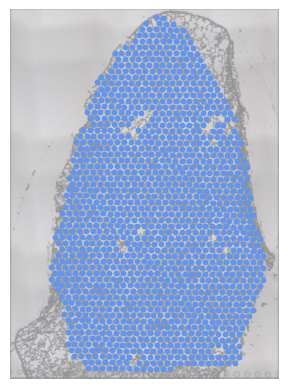

In [55]:
# tissue_dir = root_dir + 'lungs_images/M24.png'
img = plt.imread(adata_M24.uns['lung_image'])
fig, ax = plt.subplots()
ax.imshow(img, extent=adata_M24.uns['extent'])

plt.scatter(adata_M24.obsm['spatial'][:,0],
            adata_M24.obsm['spatial'][:,1],
            s=10,
            c='cornflowerblue')
ax.invert_yaxis()
ax.axis('off')

Similarly, we build anndata and plot the tissue for the rest of the samples. I won't execute these blocks of code, because it exceeded the memory.

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


(1000.0, 5900.0, 6400.0, 1100.0)

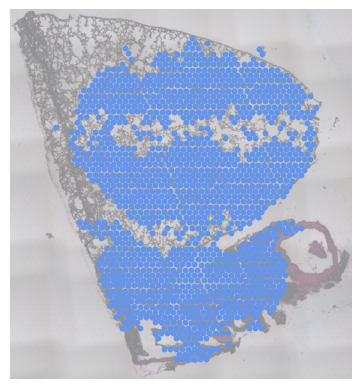

In [57]:
count_matrix = root_dir + 'raw_counts/GSM5690364_0_Per_2_F31.txt'
coor_matrix = root_dir + 'spatial_coord/0_Per_2_F31-Projection.csv'
adata_F31 = build_adata(coor_matrix, count_matrix)
adata_F31.uns['extent'] = [1000, 5900, 1100, 6400]
adata_F31.uns['lung_image'] = root_dir + 'lungs_images/F31.png'

img = plt.imread(adata_F31.uns['lung_image'])
fig, ax = plt.subplots()
ax.imshow(img, extent=adata_F31.uns['extent'])

plt.scatter(adata_F31.obsm['spatial'][:,0],
            adata_F31.obsm['spatial'][:,1],
            s=10,
            c='cornflowerblue')
ax.invert_yaxis()
ax.axis('off')

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


(2250.0, 5400.0, 6500.0, 2700.0)

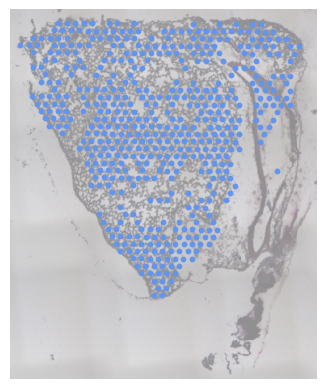

In [58]:
count_matrix = root_dir + 'raw_counts/GSM5690365_CTL_1_M63.txt'
coor_matrix = root_dir + 'spatial_coord/CTL_1_M63-Projection.csv'
adata_M63 = build_adata(coor_matrix, count_matrix)
adata_M63.uns['extent'] = [2250, 5400, 2700, 6500]
adata_M63.uns['lung_image'] = root_dir + 'lungs_images/M63.png'

img = plt.imread(adata_M63.uns['lung_image'])
fig, ax = plt.subplots()
ax.imshow(img, extent=adata_M63.uns['extent'])

plt.scatter(adata_M63.obsm['spatial'][:,0],
            adata_M63.obsm['spatial'][:,1],
            s=10,
            c='cornflowerblue')
ax.invert_yaxis()
ax.axis('off')

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


(2670.0, 6300.0, 5600.0, 2900.0)

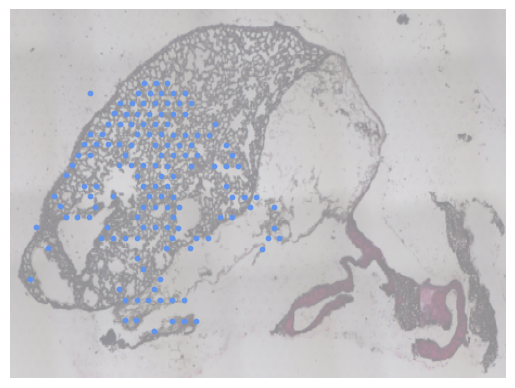

In [59]:
count_matrix = root_dir + 'raw_counts/GSM5690366_CTL_2_F62.txt'
coor_matrix = 'spatial_coord/CTL_2_F62-Projection.csv'
adata_F62 = build_adata(coor_matrix, count_matrix)
adata_F62.uns['extent'] = [2670, 6300, 2900, 5600]
adata_F62.uns['lung_image'] = root_dir + 'lungs_images/F62.png'

img = plt.imread(adata_F62.uns['lung_image'])
fig, ax = plt.subplots()
ax.imshow(img, extent=adata_F62.uns['extent'])

plt.scatter(adata_F62.obsm['spatial'][:,0],
            adata_F62.obsm['spatial'][:,1],
            s=10,
            c='cornflowerblue')
ax.invert_yaxis()
ax.axis('off')

Once the data containers are set up for each sample, they can be saved to disk for reuse.

In [60]:
adata_dir = root_dir + 'Raw_Initial_Data/'
adata_M24.write_h5ad(adata_dir + 'raw_M24.h5ad')
adata_F31.write_h5ad(adata_dir + 'raw_F31.h5ad')
adata_M63.write_h5ad(adata_dir + 'raw_M63.h5ad')
adata_F62.write_h5ad(adata_dir + 'raw_F62.h5ad')